In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras import backend as K

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [2]:
img_rows = 28
img_cols = 28
channels = 1

img_shape = (img_rows, img_cols, channels)

z_dim = 100
num_classes = 10

일부 데이터만 레이블을 사용하고 나머지는 레이블이 없는것으로 간주

In [3]:
class Dataset:
  def __init__(self,num_labeled):
    self.num_labeled = num_labeled #훈련에 사용할 레이블된 샘플 개수
    (self.x_train, self.y_train), (self.x_test, self.y_test) = mnist.load_data()

    def preprocess_imgs(x):
      x = (x.astype(np.float32) - 127.5) / 127.5
      x = np.expand_dims(x,axis= 3)
      return x

    def preprocess_labels(y):
      return y.reshape(-1, 1)

    self.x_train = preprocess_imgs(self.x_train)
    self.y_train = preprocess_labels(self.y_train)

    self.x_test = preprocess_imgs(self.x_test)
    self.y_test = preprocess_labels(self.y_test)

  def batch_labeled(self, batch_size):
    idx = np.random.randint(0, self.num_labeled, batch_size)
    imgs = self.x_train[idx]
    labels = self.y_train[idx]
    return imgs, labels

  def batch_unlabeled(self, batch_size):
    idx = np.random.randint(self.num_labeled, self.x_train.shape[0], batch_size)
    imgs = self.x_train[idx]

    return imgs

  def training_set(self):
    x_train = self.x_train[range(self.num_labeled)]
    y_train = self.y_train[range(self.num_labeled)]
    return x_train, y_train

  def test_set(self):
    return self.x_test, self.y_test

label된 이미지 100개만 사용

In [4]:
num_labeled = 100

dataset = Dataset(num_labeled)

### Generator

In [5]:
def build_generator(z_dim): #DCGAN과 동일
  model = Sequential()
  model.add(Dense(256 * 7 * 7, input_dim = z_dim))
  model.add(Reshape((7, 7, 256)))
  model.add(Conv2DTranspose(128, kernel_size = 3, strides = 2, padding ='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha = 0.01))
  model.add(Conv2DTranspose(64, kernel_size = 3, strides = 1, padding ='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha = 0.01))
  model.add(Conv2DTranspose(1, kernel_size =3, strides = 2, padding ='same'))
  model.add(Activation('tanh'))
  return model

### Discriminator

진짜와 가짜 구별을 위한 판별, 진짜일 경우 레이블 판별

In [6]:
def build_discriminator_net(img_shape):
  model = Sequential()
  model.add(Conv2D(32, kernel_size = 3, strides = 2, padding ='same', input_shape = img_shape))
  model.add(LeakyReLU(alpha = 0.01))

  model.add(Conv2D(64, kernel_size = 3, strides = 2, padding = 'same'))
  model.add(LeakyReLU(alpha = 0.01))

  model.add(Conv2D(128, kernel_size = 3, strides = 2, padding = 'same'))
  model.add(LeakyReLU(alpha = 0.01))

  model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dense(num_classes))

  return model

10개의 뉴런을 가진 fully-connected layer로 끝남. 다음 두 개의 판별차 출력을 계산하는 신경망을 정의해야함

하나는 지도 학습(다중 분류), 하나는 비지도 학습(이진 분류)

In [7]:
def build_discriminator_supervised(discriminator_net):
  model = Sequential()
  model.add(discriminator_net)
  model.add(Activation('softmax'))
  return model

In [8]:
def build_discriminator_unsupervised(discriminator_net):
  model = Sequential()
  model.add(discriminator_net)
  
  def predict(x):
    prediction = 1.0 - (1.0 / (K.sum(K.exp(x), axis = -1, keepdims = True) + 1.0))
    #진짜 클래스에 대한 확률 분포를 진짜 대 가짜의 이진 확률로 변환
    return prediction

  model.add(Lambda(predict))

  return model

In [9]:
def build_gan(generator, discriminator):
  model = Sequential()
  model.add(generator)
  model.add(discriminator)
  return model

discriminator_net = build_discriminator_net(img_shape)
# 판별자 기반 모델, 지도 비지도 학습에 모두 공유
discriminator_supervised = build_discriminator_supervised(discriminator_net)
discriminator_supervised.compile(loss = 'categorical_crossentropy', metrics = ['accuracy'], optimizer = Adam(learning_rate = 0.0003))

discriminator_unsupervised = build_discriminator_unsupervised(discriminator_net)
discriminator_unsupervised.compile(loss = 'binary_crossentropy',  optimizer = Adam())

generator = build_generator(z_dim)

discriminator_unsupervised.trainable = False

gan = build_gan(generator, discriminator_unsupervised)
gan.compile(loss = 'binary_crossentropy', optimizer = Adam())
#생성자 훈련을 위해 비지도 학습용 판별자 사용

## SGAN 훈련 알고리즘

1. (지도학습) 판별자 훈련
- 레이블된 진짜 샘플 (x, y)의 랜덤 미니배치를 얻음
- 주어진 미니배치에 대한 D((x, y))를 계산하고 다중 분류 손실을 역전파하여 판별자의 파라미터를 업데이트하고 손실을 최소화
2. (비지도학습) 판별자 훈련
- 레이블이 없는 진짜 샘플 x의 랜덤 미니배치를 얻음
- 주어진 미니배치에 대한 D(x)를 계산하고 이진 분류 손실을 역전파하여 판별자의 파라미터를 업데이트하고 손실을 최소화
- 랜덤한 벡터 z의 미니배치를 얻어 가짜 샘플 G(z) = x*의 미니배치 생성
- 주어진 미니배치에 대한 D(x*)를 계산하고 이진 분류 손실을 역전파하여 판별자의 파라미터를 업데이트하고 손실을 최소화
3. 생성자 훈련
- 랜덤한 벡터 z의 미니배치를 얻어 가짜 샘플 G(z) = x*의 미니배치 생성
- 주어진 미니배치에 대한 D(x*)를 계산하고 이진 분류 손실을 역전파하여 생성자의 파라미터를 업데이트하고 손실을 최대화

In [10]:
supervised_losses = []
iteration_checkpoint = []

def train(iterations, batch_size, sample_interval):
  real = np.ones((batch_size, 1))
  fake = np.zeros((batch_size, 1))

  for iteration in range(iterations):
    imgs, labels = dataset.batch_labeled(batch_size)
    labels = to_categorical(labels, num_classes = num_classes) #label 원핫인코딩
    imgs_unlabeled = dataset.batch_unlabeled(batch_size)

    z = np.random.normal(0, 1, (batch_size, z_dim))
    gen_imgs = generator.predict(z)

    d_loss_supervised, accuracy = discriminator_supervised.train_on_batch(imgs, labels)

    d_loss_real = discriminator_unsupervised.train_on_batch(imgs_unlabeled, labels, real)

    d_loss_fake = discriminator_unsupervised.train_on_batch(gen_imgs, fake)
    
    d_loss_unsupervised =0.5 * np.add(d_loss_real, d_loss_fake)

    z = np.random.normal(0, 1, (batch_size, z_dim))
    gen_imgs = generator.predict(z)

    g_loss = gan.train_on_batch(z, np.ones((batch_size, 1)))

    if (iteration + 1) % sample_interval == 0:
      supervised_losses.append(d_loss_supervised)
      iteration_checkpoint.append(iteration + 1)

      print("%d [D loss supervised: %.4f, acc.: %.2f%%] [D loss unsupervised: %.4f] [G loss: %f]"
                % (iteration + 1, d_loss_supervised, 100 * accuracy,
                d_loss_unsupervised, g_loss))

### 훈련

In [11]:
iterations = 8000
batch_size = 32
sample_interval = 800

train(iterations, batch_size, sample_interval)

800 [D loss supervised: 0.1423, acc.: 100.00%] [D loss unsupervised: 0.2023] [G loss: 3.863817]
1600 [D loss supervised: 0.0787, acc.: 100.00%] [D loss unsupervised: 0.1976] [G loss: 3.684334]
2400 [D loss supervised: 0.2394, acc.: 96.88%] [D loss unsupervised: 0.2063] [G loss: 3.141531]
3200 [D loss supervised: 0.1775, acc.: 100.00%] [D loss unsupervised: 0.2160] [G loss: 3.398209]
4000 [D loss supervised: 0.1260, acc.: 100.00%] [D loss unsupervised: 0.2028] [G loss: 3.692574]
4800 [D loss supervised: 0.1266, acc.: 100.00%] [D loss unsupervised: 0.1998] [G loss: 3.398456]
5600 [D loss supervised: 0.1052, acc.: 100.00%] [D loss unsupervised: 0.1978] [G loss: 3.388687]
6400 [D loss supervised: 0.0788, acc.: 100.00%] [D loss unsupervised: 0.2019] [G loss: 3.264758]
7200 [D loss supervised: 0.1468, acc.: 100.00%] [D loss unsupervised: 0.2055] [G loss: 3.321224]
8000 [D loss supervised: 0.1160, acc.: 100.00%] [D loss unsupervised: 0.2018] [G loss: 3.455231]


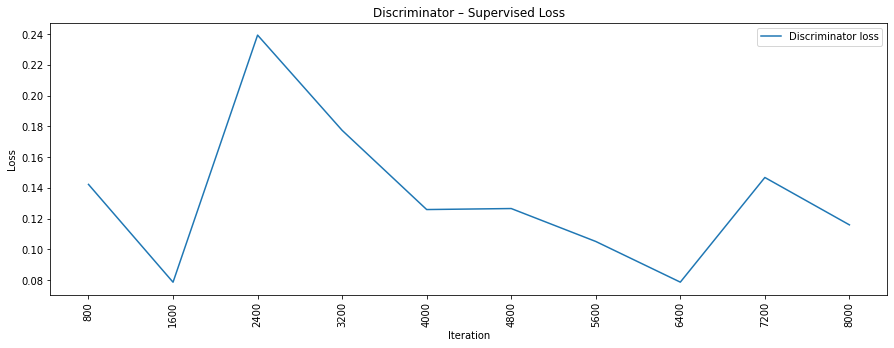

In [13]:
losses = np.array(supervised_losses)

plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoint, losses, label="Discriminator loss")

plt.xticks(iteration_checkpoint, rotation=90)

plt.title("Discriminator – Supervised Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()

### 정확도 체크

In [14]:
x ,y = dataset.test_set()
y = to_categorical(y, num_classes =num_classes)

_, accuracy = discriminator_supervised.evaluate(x, y)
print('테스트 정확도 : %.2f%%' % (100 * accuracy))

313/313 [==============================] - 2s 6ms/step - loss: 1.0486 - accuracy: 0.6905
테스트 정확도 : 69.05%


### 완전한 지도 학습 분류기와 비교

In [15]:
# SGAN 판별자와 같은 네트워크 구조를 가진 지도 학습 분류기
mnist_classifier = build_discriminator_supervised(build_discriminator_net(img_shape))
mnist_classifier.compile(loss='categorical_crossentropy',
                         metrics=['accuracy'],
                         optimizer=Adam())

In [16]:
imgs, labels = dataset.training_set()

# 레이블을 원-핫 인코딩합니다.
labels = to_categorical(labels, num_classes=num_classes)

# 분류기를 훈련합니다.
training = mnist_classifier.fit(x=imgs,
                                y=labels,
                                batch_size=32,
                                epochs=30,
                                verbose=1)
losses = training.history['loss']
accuracies = training.history['accuracy']

Epoch 1/30
4/4 [==============================] - 1s 51ms/step - loss: 2.2972 - accuracy: 0.1100
Epoch 2/30
4/4 [==============================] - 0s 8ms/step - loss: 2.2025 - accuracy: 0.2200
Epoch 3/30
4/4 [==============================] - 0s 9ms/step - loss: 2.1001 - accuracy: 0.2900
Epoch 4/30
4/4 [==============================] - 0s 10ms/step - loss: 1.9652 - accuracy: 0.3300
Epoch 5/30
4/4 [==============================] - 0s 10ms/step - loss: 1.7862 - accuracy: 0.4500
Epoch 6/30
4/4 [==============================] - 0s 9ms/step - loss: 1.6409 - accuracy: 0.4200
Epoch 7/30
4/4 [==============================] - 0s 9ms/step - loss: 1.3706 - accuracy: 0.6300
Epoch 8/30
4/4 [==============================] - 0s 9ms/step - loss: 1.1645 - accuracy: 0.7100
Epoch 9/30
4/4 [==============================] - 0s 9ms/step - loss: 0.8618 - accuracy: 0.7900
Epoch 10/30
4/4 [==============================] - 0s 9ms/step - loss: 0.6386 - accuracy: 0.8000
Epoch 11/30
4/4 [===================

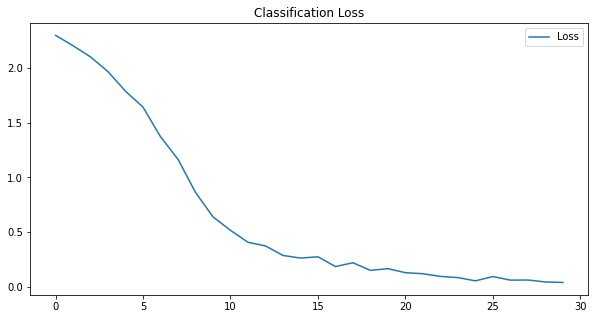

In [17]:
# 분류 손실을 그립니다
plt.figure(figsize=(10, 5))
plt.plot(np.array(losses), label="Loss")
plt.title("Classification Loss")
plt.legend()
plt.show()

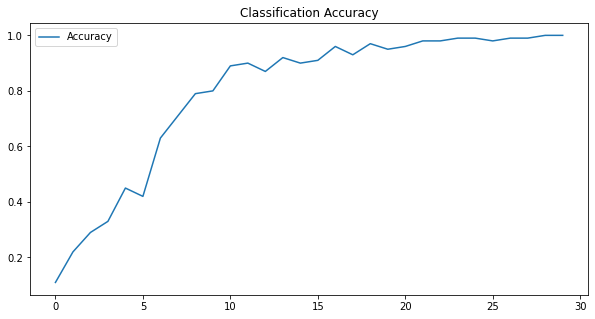

In [18]:
# 분류 정확도를 그립니다.
plt.figure(figsize=(10, 5))
plt.plot(np.array(accuracies), label="Accuracy")
plt.title("Classification Accuracy")
plt.legend()
plt.show()

In [19]:
x, y = dataset.test_set()
y = to_categorical(y, num_classes=num_classes)

# 테스트 세트에 대한 분류 정확도를 계산합니다.
_, accuracy = mnist_classifier.evaluate(x, y)
print("Test Accuracy: %.2f%%" % (100 * accuracy))

313/313 [==============================] - 2s 6ms/step - loss: 1.2594 - accuracy: 0.7018
Test Accuracy: 70.18%
